In [1]:
import pandas as pd
import numpy as np 
from scipy import stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import gc
import lightgbm as lgb
import keras.backend as K
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
  
def calBS(row):
    
    T = row['TTM'] / 365.242
    
    if T == 0:
        T += 1 / 365.242
    
    r = row['ir_3m_mid'] / 100
    vol = row['obx_total_60D_vol'] 
    
    d1 = (np.log(row['obx_price'] / row['strike']) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(row['obx_price'] / row['strike']) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    if row['type'] == "CALL":
        optionPrice = row['obx_price'] * stats.norm.cdf(d1) - row['strike'] * np.exp(-r * T) * stats.norm.cdf(d2)
    elif row['type'] == "PUT":
        optionPrice = row['strike'] * np.exp(-r * T) * stats.norm.cdf(-d2) - row['obx_price'] * stats.norm.cdf(-d1)

    return optionPrice

def calDeltaBS(row):
    
    T = row['TTM'] / 365.242
    
    if T == 0:
        T += 1 / 365.242
    
    r = row['ir_3m_mid'] / 100
    vol = row['obx_total_60D_vol'] 
    
    d1 = (np.log(row['obx_price'] / row['strike']) + (r + 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    d2 = (np.log(row['obx_price'] / row['strike']) + (r - 0.5 * vol ** 2) * T) / (vol * np.sqrt(T))
    
    if row['type'] == 1:
        delta = stats.norm.cdf(d1) 
    elif row['type'] == 0:
        delta = stats.norm.cdf(d1) - 1

    return delta


def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5

SEED = 2019 
np.random.seed(SEED)

Using TensorFlow backend.


In [2]:
df = pd.read_csv('../input/thesis_data_all_cols.csv')
df = df.sort_values('date')

In [3]:
df['moneyness'] = df['obx_price'] / df['strike']
df['opt_id'] = df['type'].astype(str) + '_' + df['strike'].astype(str) + '_' + df['maturity_date'].astype(str)

stats_cols = ['market_price', 'strike', 'obx_price', 'TTM', 'obx_60D_vol', 'ir_3m_mid']
df[stats_cols].describe()

,market_price,strike,obx_price,TTM,obx_60D_vol,ir_3m_mid
count,556082.00000,556082.000000,556082.000000,556082.000000,556082.000000,556082.000000
mean,37.98147,543.120268,555.178373,107.102951,0.001376,1.480485
std,45.77118,153.283512,134.826822,93.918179,0.000515,0.531900
min,0.01000,250.000000,301.030000,0.000000,0.000678,0.605000
25%,2.67500,430.000000,453.977500,36.000000,0.000987,1.075000
50%,18.37500,500.000000,542.035300,73.000000,0.001218,1.340000
75%,60.87500,640.000000,625.190000,161.000000,0.001664,1.685000
max,331.25000,1080.000000,881.010000,372.000000,0.003294,3.230000


In [4]:
df = df[df.type == 'CALL']

volume_filter = df.groupby('opt_id')['volume'].max().reset_index()
no_volume = volume_filter[volume_filter.volume == 0].opt_id

df = df.set_index('opt_id').drop(no_volume, axis=0)

In [5]:
df = df.reset_index()

In [6]:
df['T_t'] = df['TTM'] / 365.242
df['normalized_market_price'] = df['market_price'] / df['strike']

In [7]:
df.head()

,opt_id,date,market_price,ask_price,bid_price,open_price,high_price,low_price,strike,volume,open_interest,type,maturity,ir_1m_mid,ir_1m_bid,ir_1m_ask,ir_3m_mid,ir_3m_bid,ir_3m_ask,ir_6m_mid,ir_6m_bid,ir_6m_ask,obx_return,obx_60D_vol,obx_price,obx_total_return,obx_total_60D_vol,obx_total_price,maturity_date,TTM,moneyness,T_t,normalized_market_price
0,CALL_415.0_2011-07-21,2011-01-18,23.000,NaN,NaN,23.000,23.000,23.000,415.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,0.976434,0.503776,0.055422
1,CALL_410.0_2011-07-21,2011-01-18,25.750,NaN,NaN,25.750,25.750,25.750,410.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,0.988341,0.503776,0.062805
2,CALL_405.0_2011-07-21,2011-01-18,28.500,NaN,NaN,28.500,28.500,28.500,405.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,1.000543,0.503776,0.070370
3,CALL_400.0_2011-07-21,2011-01-18,31.875,NaN,NaN,31.875,31.875,31.875,400.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,1.013050,0.503776,0.079687
4,CALL_395.0_2011-07-21,2011-01-18,34.875,NaN,NaN,34.875,34.875,34.875,395.0,0.0,0.0,CALL,JUL11,2.21,2.06,2.36,2.475,2.34,2.61,2.68,2.58,2.78,0.0107,0.001423,405.22,0.009982,0.001325,443.16,2011-07-21,184,1.025873,0.503776,0.088291


In [8]:
cutoff = int(np.round(df.shape[0] * 0.8))
X_trn, y_trn = df[:cutoff].copy(), df[:cutoff]['normalized_market_price'].copy()
X_val, y_val = df[cutoff:].copy(), df[cutoff:]['normalized_market_price'].copy()

In [9]:
# def build_nn_model(feats):
#     model = models.Sequential()
    
#     model.add(layers.Dense(256, activation='tanh',
#                             input_shape=(len(feats),)))  
    
#     model.add(layers.Dense(128, activation='tanh'))  
    
#     model.add(layers.Dense(64, activation='tanh'))   
    
#     model.add(layers.Dense(32, activation='tanh'))
    
#     model.add(layers.Dense(16, activation='tanh'))    
    
#     model.add(layers.Dense(1))
#     model.compile(optimizer='Nadam', loss='mse', metrics=['mse'])
    
#     return model


def build_nn_model(feats):
    model = models.Sequential()
    
    model.add(layers.Dense(128, activation='tanh',
                            input_shape=(len(feats),)))  
    
    model.add(layers.Dense(64, activation='tanh'))  
    
    model.add(layers.Dense(32, activation='tanh'))   
    
    model.add(layers.Dense(16, activation='tanh'))
    
    model.add(layers.Dense(1))
    model.compile(optimizer='Nadam', loss='mse', metrics=['mse'])
    
    return model


# def build_nn_model(feats):
#     model = models.Sequential()
    
#     model.add(layers.Dense(128, activation='relu',
#                             input_shape=(len(feats),)))  
    
#     model.add(layers.Dense(64, activation='relu'))  
    
#     model.add(layers.Dense(32, activation='relu'))   
    
#     model.add(layers.Dense(16, activation='relu'))
    
#     model.add(layers.Dense(1))
#     model.compile(optimizer='rmsprop', loss='mse', metrics=['mse'])
    
#     return model



def train_nn(X_train, y_train, X_validation, y_validation, feats):

    train_epochs = 200
    batch_size = 128

    train_x, train_y = X_train[feats], y_train
    valid_x, valid_y = X_validation[feats], y_validation

    train_oof = np.zeros(train_x.shape[0])

    nn_model = build_nn_model(feats)
    file_path = "nn_hedging.hdf5"

    early_stop = EarlyStopping(patience=10)
    lr_schd = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=5e-5, verbose=0)
    check_point = ModelCheckpoint(file_path, monitor = "val_loss", mode = "min", save_best_only = True, verbose = 1)

    history = nn_model.fit(x=train_x, y=train_y,
                    validation_data=(valid_x, valid_y),
                    epochs=train_epochs, verbose = 1, batch_size=batch_size, 
                    callbacks = [early_stop, lr_schd, check_point])

    nn_model.load_weights(file_path) # load weight with best validation score

    train_oof = nn_model.predict(valid_x, batch_size=batch_size).ravel()

    print("nn rmse : {}".format(rmse(valid_y, train_oof)))
    print("nn mse : {}".format(mean_squared_error(valid_y, train_oof)))
    print("nn mae : {}".format(mean_absolute_error(valid_y, train_oof)))
    print("nn me : {}".format((valid_y - train_oof).mean()))
    
    return nn_model, train_oof

In [10]:
fts_to_use = ['moneyness', 'T_t']
nn_model, train_oof = train_nn(X_trn, y_trn, X_val, y_val, feats=fts_to_use)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 120646 samples, validate on 30161 samples
Epoch 1/200
120646/120646 [==============================] - 7s 59us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0011 - val_mean_squared_error: 0.0011

Epoch 00001: val_loss improved from inf to 0.00106, saving model to nn_hedging.hdf5
Epoch 2/200
120646/120646 [==============================] - 4s 32us/step - loss: 6.3915e-04 - mean_squared_error: 6.3915e-04 - val_loss: 4.8291e-04 - val_mean_squared_error: 4.8291e-04

Epoch 00002: val_loss improved from 0.00106 to 0.00048, saving model to nn_hedging.hdf5
Epoch 3/200
120646/120646 [==============================] - 4s 32us/step - loss: 6.0875e-04 - mean_squared_error: 6.0875e-04 - val_loss: 4.8269e-04 - val_mean_squared_error: 4.8269e-04

Epoch 00003: val_loss improved from 0.00048 to 0.00048, saving model to nn_hedging.hdf5
Epoch 4/200
120646/12064

In [11]:
X_val['nn_price'] = train_oof * X_val['strike']
rmse(X_val.market_price, X_val.nn_price)

4.17619575536542

In [12]:
eps = 0.001
X_val['moneyness_bumped'] = (X_val['obx_price'] + eps) / X_val['strike']

fts_to_use = ['moneyness_bumped', 'T_t']
X_val['nn_price'] = train_oof * X_val['strike']
X_val['NN_delta'] = (((nn_model.predict(X_val[fts_to_use], batch_size=256).ravel() - train_oof) * X_val['strike']) / eps)
X_val['NN_delta'].describe()

count    30161.000000
mean         0.442918
std          0.292927
min         -0.103286
25%          0.182306
50%          0.430346
75%          0.696182
max          1.091659
Name: NN_delta, dtype: float64

In [13]:
X_val['NN_delta'].to_pickle('nn_delta_1.pkl')

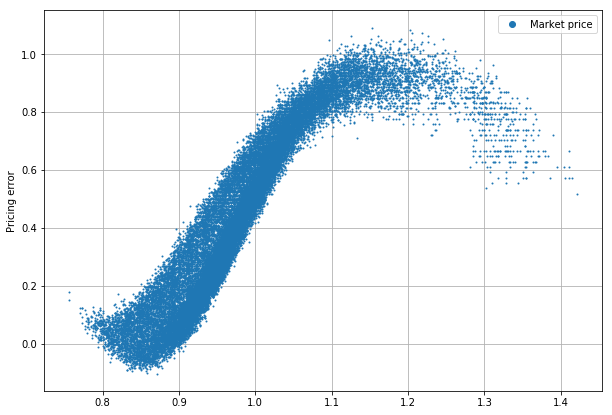

In [14]:
fig = plt.figure(figsize=(10, 7))

plt.ylabel('Pricing error')
plt.grid(True)
fig = plt.plot(X_val['moneyness'], X_val['NN_delta'], linestyle='', marker='o', markersize=1)
plt.legend(['Market price'], markerscale=6)

In [15]:
eps = 0.001
X_val['moneyness_bumped'] = (X_val['moneyness'] + eps) 

fts_to_use = ['moneyness_bumped', 'T_t']
X_val['nn_price'] = train_oof * X_val['strike']
X_val['NN_delta'] = (((nn_model.predict(X_val[fts_to_use], batch_size=256).ravel() - train_oof) * X_val['strike']) / eps) /  X_val['strike']
X_val['NN_delta'].describe()

count    30161.000000
mean         0.444677
std          0.291110
min         -0.060059
25%          0.184137
50%          0.432681
75%          0.698291
max          0.974163
Name: NN_delta, dtype: float64

In [16]:
X_val['NN_delta'].to_pickle('nn_delta_2.pkl')

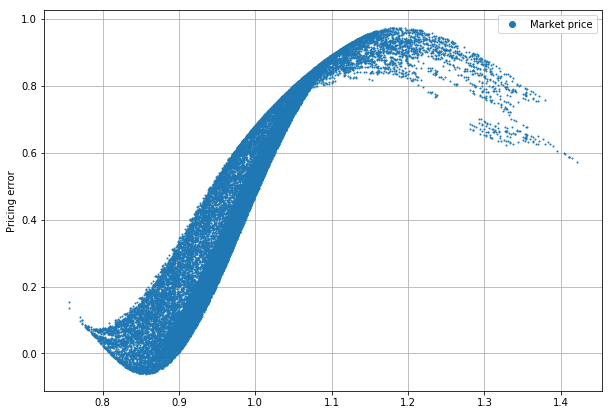

In [17]:
fig = plt.figure(figsize=(10, 7))

plt.ylabel('Pricing error')
plt.grid(True)
fig = plt.plot(X_val['moneyness'], X_val['NN_delta'], linestyle='', marker='o', markersize=1)
plt.legend(['Market price'], markerscale=6)